<a href="https://colab.research.google.com/github/volodymyr-podkopaiev/portfolio/blob/main/Portfolio_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery

# Replace 'your-gcp-project-id' with your actual project ID
project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)

In [ ]:
# Define your SQL query
sql_query = """
SELECT
  s.date,
  s.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.medium,
  sp.channel,
  acc.id,
  acc.is_verified,
  acc.is_unsubscribed,
  p.category,
  p.name,
  p.price,
  p.short_description
FROM `DA.session` s
LEFT JOIN `DA.order` AS o ON s.ga_session_id = o.ga_session_id
LEFT JOIN `DA.product` AS p ON p.item_id = o.item_id
LEFT JOIN `DA.session_params` AS sp ON sp.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account_session` AS accs ON accs.ga_session_id = s.ga_session_id
LEFT JOIN `DA.account` acc ON acc.id = accs.account_id
"""

# Run the query and store the results in a pandas DataFrame
df = client.query(sql_query).to_dataframe()

# Display the first few rows of the DataFrame
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  id                 27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  name               33538 non-null   object 
 16  pr

None

Після SQL запиту отримали датасет з 18 колонками.
  5 колонок: ga_session_id, id, is_verified, is_unsubscribed, price - e числовими (price - дійсні числа float, інші колонки - цілі int).<b>Колонка date - дата (потрібно перетворити до типу datetime).
  12 колонок типу object: continent, country, device, browser, mobile_model_name, operating_system, language, medium, channel, category, name, short_description.

In [ ]:
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
categories = ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'medium', 'channel', 'category']
df[categories] = df[categories].apply(lambda x: x.astype('category'))
display(df.info())
display(f'Start time: {df["date"].min()}')
display(f'End time: {df["date"].max()}')
display(f'Unique sessions: {df["ga_session_id"].nunique()}')
display(f'Sessions with orderd: {df["ga_session_id"].nunique()-df["price"].isna().sum()}')
display(f'Sessions without language: {df["language"].isna().sum()}')
display(f'Unique users: {df["id"].nunique()}')
missing = df.isna().sum()
display(missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               349545 non-null  datetime64[ns]
 1   ga_session_id      349545 non-null  Int64         
 2   continent          349545 non-null  category      
 3   country            349545 non-null  category      
 4   device             349545 non-null  category      
 5   browser            349545 non-null  category      
 6   mobile_model_name  349545 non-null  category      
 7   operating_system   349545 non-null  category      
 8   language           235279 non-null  category      
 9   medium             349545 non-null  category      
 10  channel            349545 non-null  category      
 11  id                 27945 non-null   Int64         
 12  is_verified        27945 non-null   Int64         
 13  is_unsubscribed    27945 non-null   Int64   

None

'Start time: 2020-11-01 00:00:00'

'End time: 2021-01-31 00:00:00'

'Unique sessions: 349545'

'Sessions with orderd: 33538'

'Sessions without language: 114266'

'Unique users: 27945'

,0
language,114266
id,321600
is_verified,321600
is_unsubscribed,321600
category,316007
name,316007
price,316007
short_description,316007


Маємо 349 545 унікальних сесій. Сесій які закінчились замовленнями - 33 538.Розглядаємо період 01 листопада 2020 - 27 січня 2021. Найбільше пропусків маємо в колонках: id, is_verified, is_unsubscribed з причини того що не всі сесії створені зареєстрованими користувачами. Оскільки за завданням нам потрібно зробити аналітику по всіх сесіях, ми не можемо видалити строки з відсутніми даними, а також не можемо змінити тип колонок is_verified, is_unsbuscribed на bool для зменшення обсягу датафрейму. Також маємо відсутні дані по мові браузеру (114 266), можлива причина в cookies браузерів.

,continent,total_sum
2,Americas,17665280.0
3,Asia,7601298.3
4,Europe,5934624.2


,country,orders_count
104,United States,153470
43,India,32763
18,Canada,25994
103,United Kingdom,11003
33,France,6958


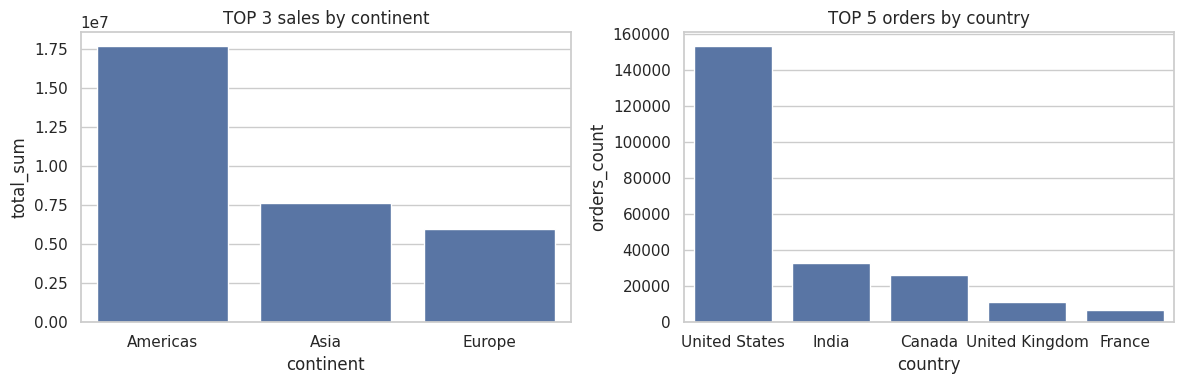

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sales_by_continent = df.groupby('continent', observed=True).agg(total_sum=('price', 'sum')).reset_index().sort_values(by = 'total_sum', ascending=False).nlargest(3, 'total_sum')
sales_by_continent['continent'] = sales_by_continent['continent'].cat.remove_unused_categories()
display(sales_by_continent)
orders_by_country = df.groupby('country', observed=True).agg(orders_count=('ga_session_id', 'count')).reset_index().sort_values(by = 'orders_count', ascending=False).nlargest(5, 'orders_count')
orders_by_country['country'] = orders_by_country['country'].cat.remove_unused_categories()
display(orders_by_country)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=sales_by_continent, y='total_sum', x='continent', ax=axes[0], order=sales_by_continent['continent'])
axes[0].set_title('TOP 3 sales by continent')
sns.barplot(data=orders_by_country, y='orders_count', x='country', ax=axes[1], order=orders_by_country['country'])
axes[1].set_title('TOP 5 orders by country')
plt.tight_layout()
plt.show()

Найбільше продажів по континентах: Америка, Азія та Європа.  Найбільше замовлень по країнах: Штати, Індія, Канада, Британія, Франція.

,category,total_sum,us_sum
0,Sofas & armchairs,8388254.5,3707144.5
1,Chairs,6147748.8,2619773.8
2,Beds,4919725.0,2213058.0
3,Bookcases & shelving units,3640818.1,1567606.9
4,Cabinets & cupboards,2336499.5,994545.5
5,Outdoor furniture,2142222.2,929245.2
6,Tables & desks,1790307.5,777865.0
7,Chests of drawers & drawer units,906562.5,382388.0
8,Bar furniture,735503.0,330805.0
9,Children's furniture,467697.0,207575.0


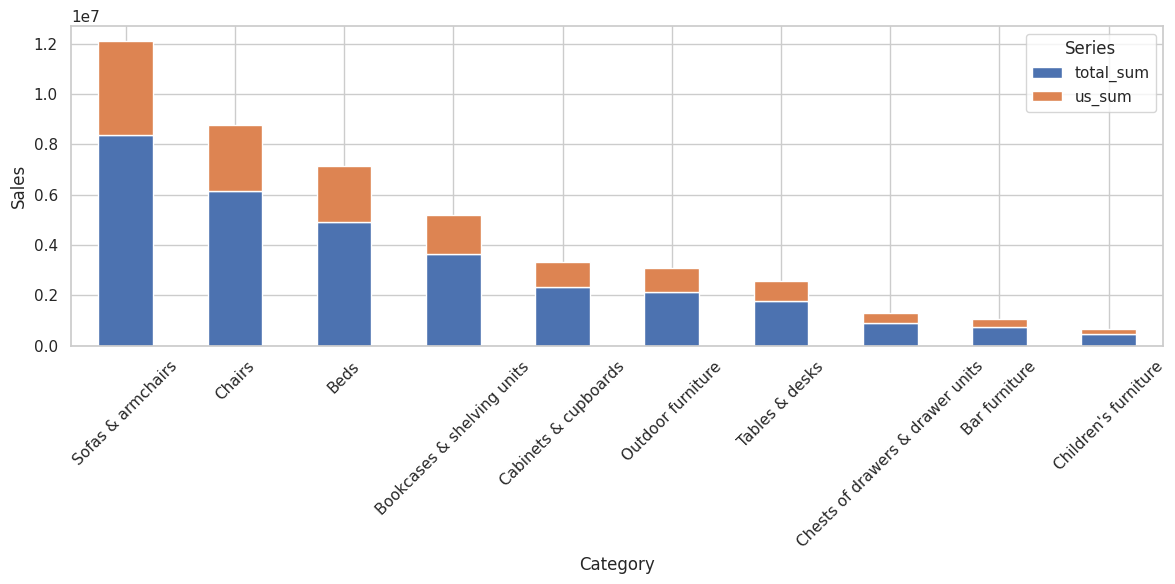

In [ ]:
total_sales_by_category = df.groupby('category', observed=True).agg(total_sum=('price', 'sum')).reset_index().sort_values(by = 'total_sum', ascending=False).nlargest(10, 'total_sum')
total_sales_by_category['category'] = total_sales_by_category['category'].cat.remove_unused_categories()
us_df = df[df['country'] == 'United States']
us_sales_by_category = us_df.groupby('category', observed=True).agg(us_sum=('price', 'sum')).reset_index().sort_values(by = 'us_sum', ascending=False).nlargest(10, 'us_sum')
us_sales_by_category['category'] = us_sales_by_category['category'].cat.remove_unused_categories()
result_df = pd.merge(total_sales_by_category, us_sales_by_category, on='category', how='inner')
display(result_df)
sns.set(style='whitegrid')
result_df.set_index('category').plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend(title='Series')
plt.tight_layout()
plt.show()


Топ-10 категорії загальних продажів повністю співпадає з топ-10 категорії продажів у Сполучених Штатах

,device,total_sum,percentage
0,desktop,18864039.0,59.002245
1,mobile,12384225.8,38.734924
2,tablet,723466.3,2.262831


,mobile_model_name,total_sum,percentage
1,Chrome,8899523.9,27.835602
0,<Other>,6535330.8,20.440966
7,Safari,6491062.1,20.302504
9,iPhone,6420776.3,20.082667
2,ChromeBook,1830458.7,5.725241
3,Edge,697222.3,2.180746
8,iPad,448854.2,1.403910
4,Firefox,421066.9,1.316998
6,Pixel 4 XL,118287.7,0.369976
5,Pixel 3,109148.2,0.341390


/tmp/ipython-input-552867693.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


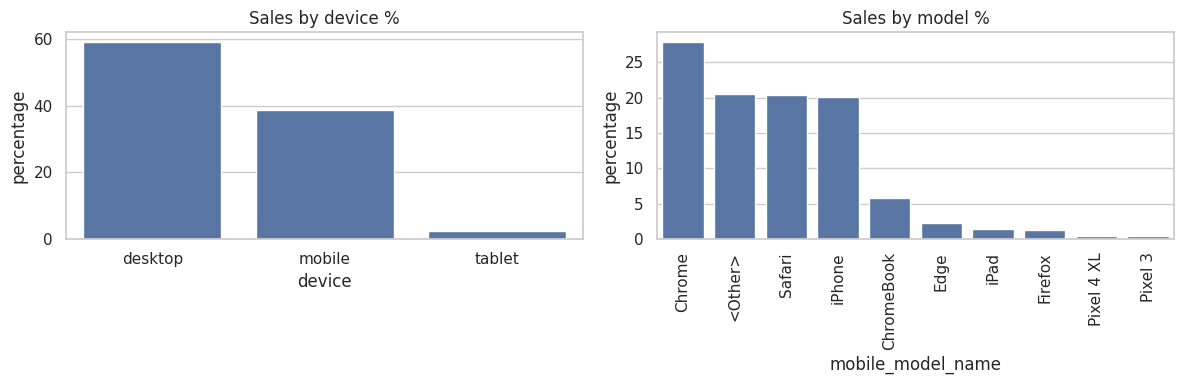

In [ ]:
device_df = df.groupby('device', observed=True).agg(total_sum=('price', 'sum'))
device_df['percentage'] = device_df / df['price'].sum() * 100
device_df = device_df.reset_index().sort_values(by='percentage', ascending=False)
display(device_df)
model_df = df.groupby('mobile_model_name', observed=True).agg(total_sum=('price', 'sum'))
model_df['percentage'] = model_df / df['price'].sum() * 100
model_df = model_df.reset_index().sort_values(by='percentage', ascending=False)
display(model_df)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=device_df, y='percentage', x='device', ax=axes[0], order=device_df['device'])
axes[0].set_title('Sales by device %')
sns.barplot(data=model_df, y='percentage', x='mobile_model_name', ax=axes[1], order=model_df['mobile_model_name'])
axes[1].set_title('Sales by model %')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Найбільше продажів у категорії девайсів - desktop. Найблільше продажів у моделі Chrome

In [ ]:
channel_df = df.groupby('channel', observed=True).agg(total_sum=('price', 'sum'))
channel_df['percentage'] = channel_df / df['price'].sum() * 100
display(channel_df.sort_values(by='percentage', ascending=False))

,total_sum,percentage
channel,,
Organic Search,11433151.6,35.760189
Paid Search,8511049.4,26.620546
Direct,7494923.4,23.442345
Social Search,2532105.7,7.919827
Undefined,2000501.0,6.257093


In [ ]:
medium_df = df.groupby('medium', observed=True).agg(total_sum=('price', 'sum'))
medium_df['percentage'] = medium_df / df['price'].sum() * 100
display(medium_df.sort_values(by='percentage', ascending=False))

,total_sum,percentage
medium,,
organic,10935239.9,34.202840
(none),7494923.4,23.442345
referral,5641855.2,17.646386
<Other>,4491351.1,14.047882
(data deleted),2041921.0,6.386645
cpc,1366440.5,4.273902


Найбільша кількість трафіку з Organic Search

'Verified users: 0.7169797817140813'

'Unsubscribed users: 0.16943997137233852'

,country,id_count
104,United States,12384
43,India,2687
18,Canada,2067
103,United Kingdom,859
33,France,553


<Figure size 800x400 with 0 Axes>

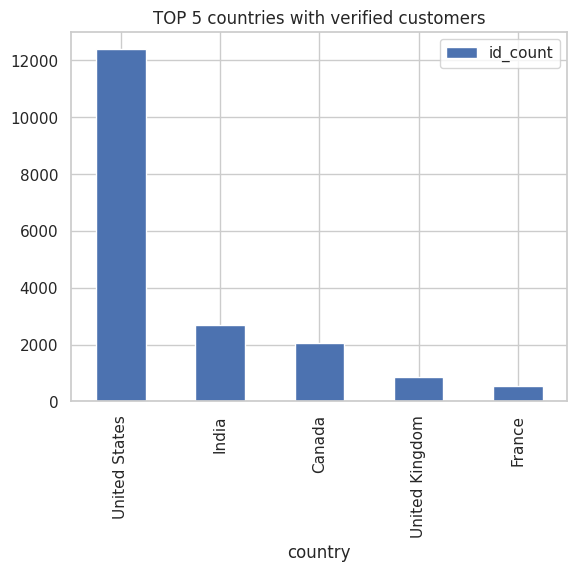

In [ ]:
registered_df = df[df['id'].notna()]
display(f'Verified users: {registered_df["is_verified"].mean()}')
display(f'Unsubscribed users: {registered_df["is_unsubscribed"].mean()}')
top_registered_by_country = registered_df.groupby('country', observed=True).agg(id_count=('id', 'count')).reset_index().sort_values(by = 'id_count', ascending=False).head(5)
display(top_registered_by_country)
sns.set_style('whitegrid')
plt.figure(figsize=(8, 4))
top_registered_by_country.plot(kind='bar', x='country', y='id_count')
plt.title('TOP 5 countries with verified customers')
plt.show()

71,5% користувачів підтвердило свою електрону пошту. 16% користувачів відписалось від розсилки. Найбліше зареєстрованих користувачів у Сполучених Штатах

# Аналіз динаміки продажів

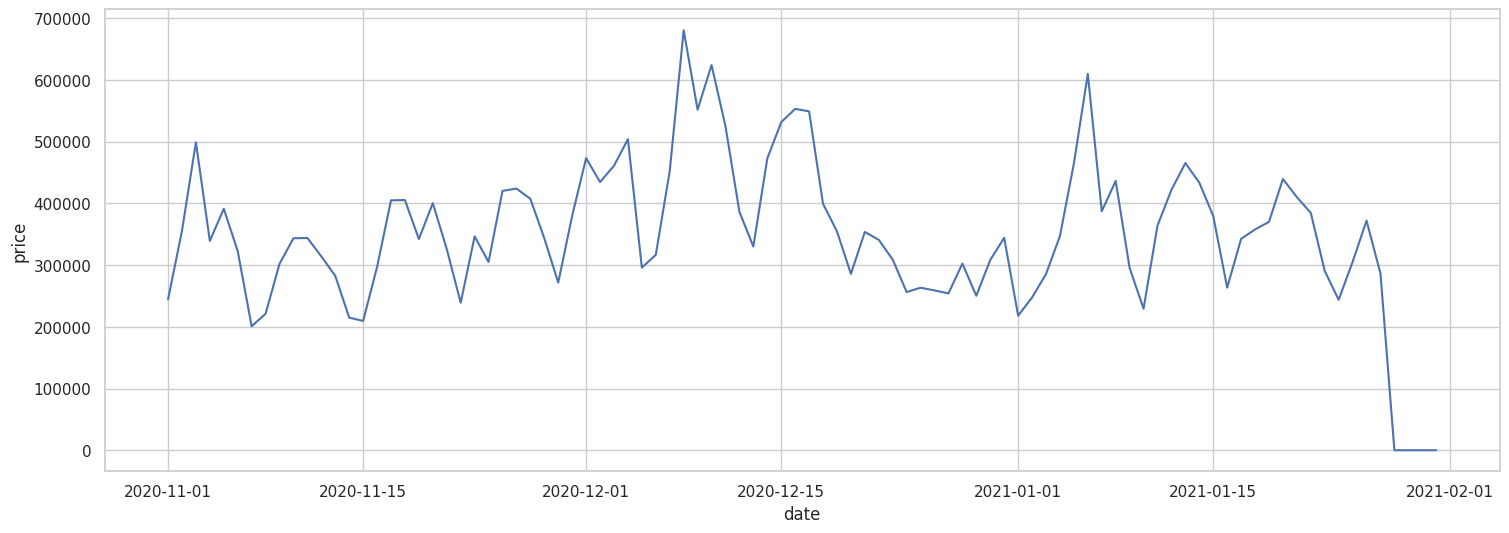

In [ ]:
dynamic_sales = df.groupby(pd.Grouper(key='date', axis=0, freq='D'))['price'].sum()
sns.set_style('whitegrid')
plt.figure(figsize=(18, 6))
sns.lineplot(data=pd.DataFrame(dynamic_sales), x='date', y='price')
plt.show()

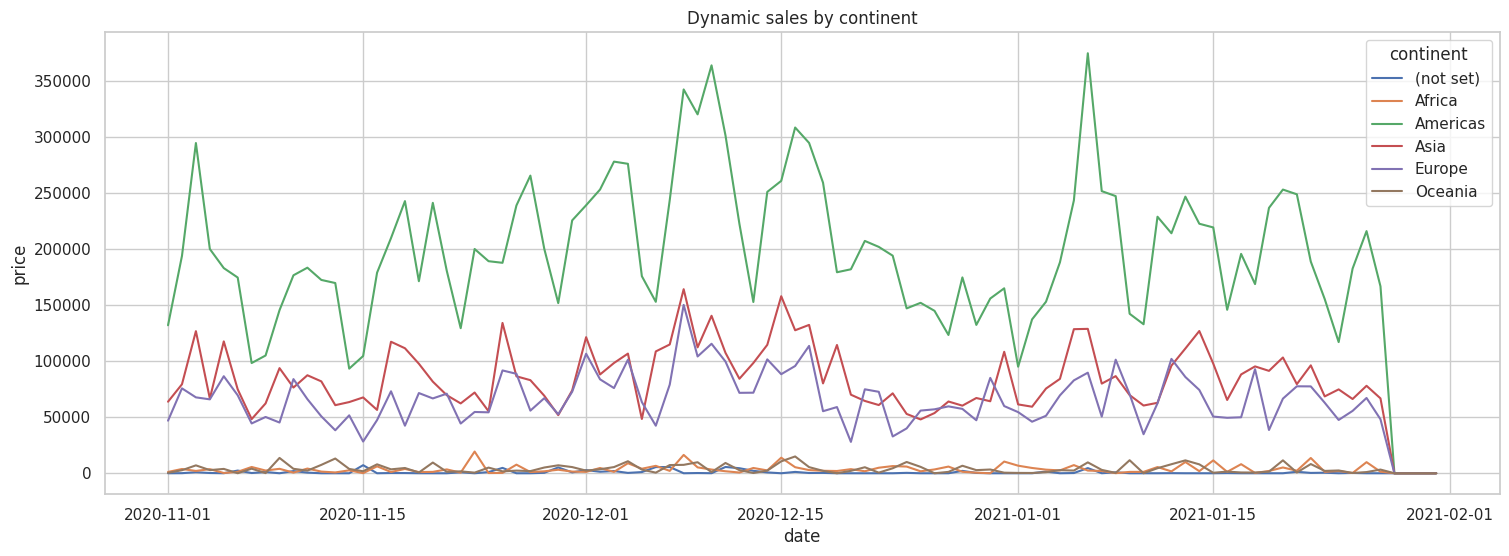

In [ ]:
dynamic_sales_by_countinent = df.groupby(['continent', pd.Grouper(key='date', axis=0, freq='D')], observed=True)['price'].sum()
sns.set_style('whitegrid')
plt.figure(figsize=(18, 6))
sns.lineplot(data=pd.DataFrame(dynamic_sales_by_countinent), x='date', y='price', hue='continent')
plt.title('Dynamic sales by continent')
plt.show()

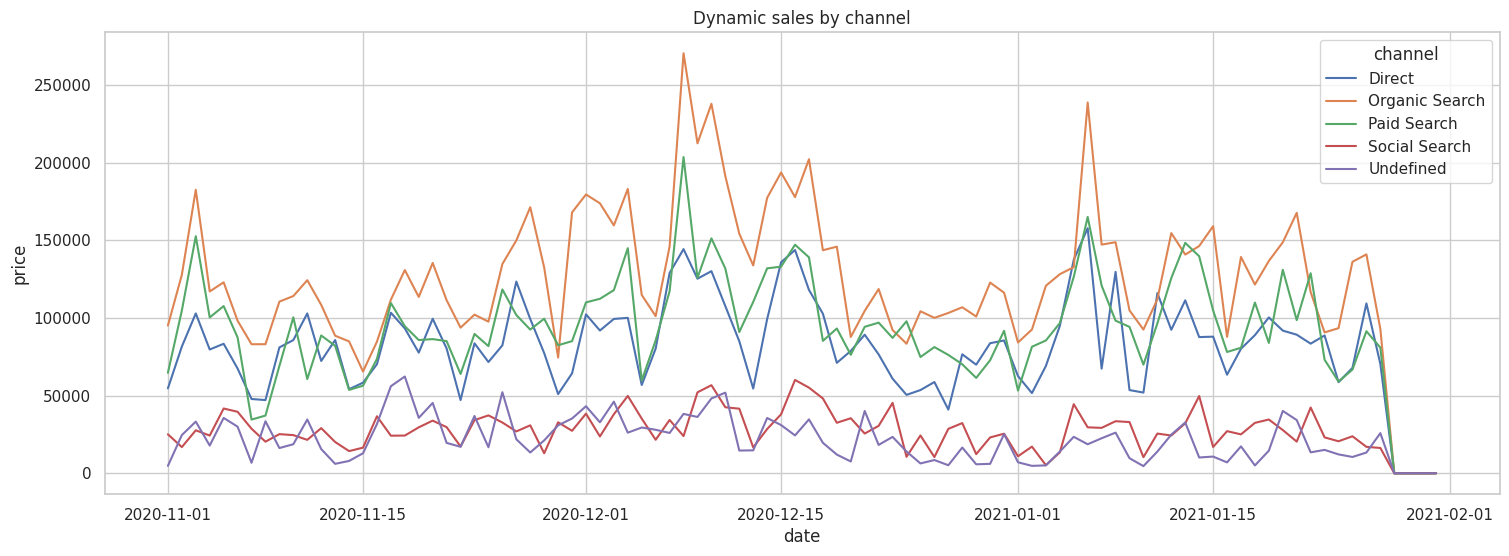

In [ ]:
dynamic_sales_by_channel = df.groupby(['channel', pd.Grouper(key='date', axis=0, freq='D')], observed=True)['price'].sum()
sns.set_style('whitegrid')
plt.figure(figsize=(18, 6))
sns.lineplot(data=pd.DataFrame(dynamic_sales_by_channel), x='date', y='price', hue='channel')
plt.title('Dynamic sales by channel')
plt.show()

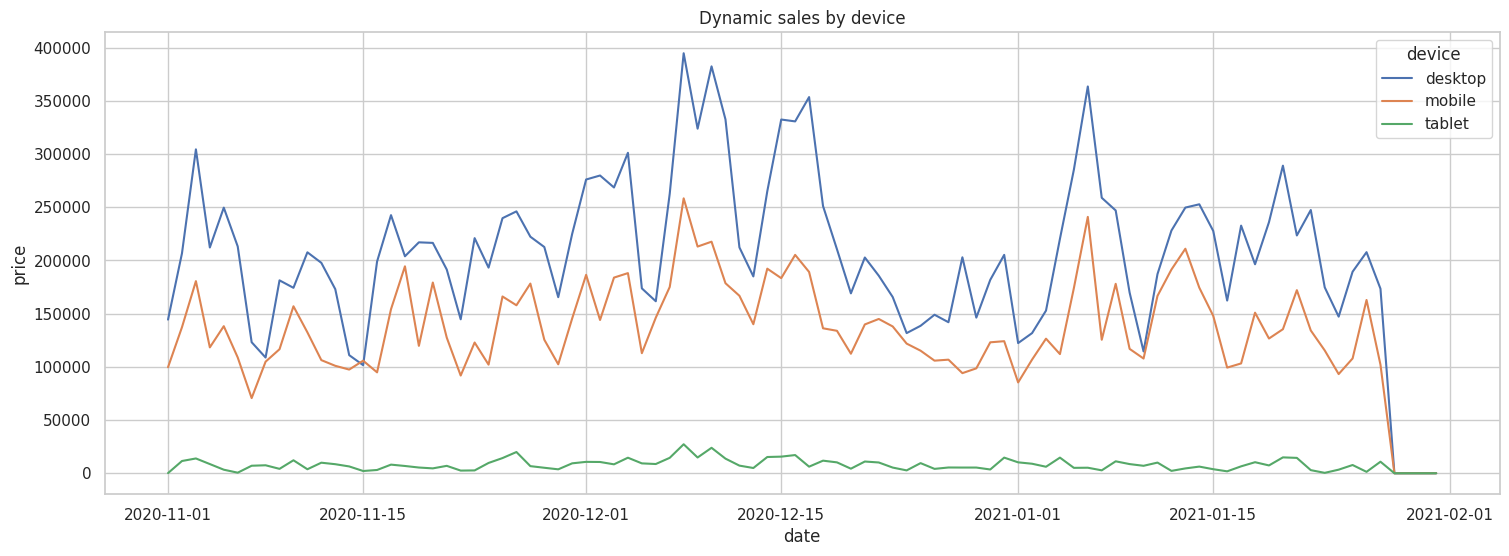

In [ ]:
dynamic_sales_by_device = df.groupby(['device', pd.Grouper(key='date', axis=0, freq='D')], observed=True)['price'].sum()
sns.set_style('whitegrid')
plt.figure(figsize=(18, 6))
sns.lineplot(data=pd.DataFrame(dynamic_sales_by_device), x='date', y='price', hue='device')
plt.title('Dynamic sales by device')
plt.show()

Дуже важко виявити сезонність, або якісь інши інтервальні впливи на динаміку продажів загальну та за крітеріями континенту, каналу трафіка або девайсів. Є суттєві зростання та падіння продажів. Скоріше за все більше впливу на обсяги продавжів здійснюється за рахунок рекламних або акціних продуктів, не сезонний вплив.

# Зведені таблиці

Зведена таблиця по каналах те девайсах

In [ ]:
pd.pivot_table(df, index='channel', columns='device', values='price', aggfunc='sum', observed=True,  fill_value=0)

device,desktop,mobile,tablet
channel,,,
Direct,4472609.4,2875317.9,146996.1
Organic Search,6794107.8,4408875.1,230168.7
Paid Search,4976977.8,3330032.6,204039.0
Social Search,1447384.8,1006707.3,78013.6
Undefined,1172959.2,763292.9,64248.9


Зведена таблиця по категоріях та странах (топ 10 категорій та топ 5 стран)

In [ ]:
category_by_country = pd.pivot_table(df, index='category', columns='country', values='price', aggfunc='sum', observed=True, fill_value=0)
top_categories = df.groupby('category', observed=True).agg(total_sum=('price', 'sum')).reset_index().sort_values(by = 'total_sum', ascending=False).nlargest(10, 'total_sum')
top_categories['category'] = top_categories['category'].cat.remove_unused_categories()
top_categories = top_categories['category'].cat.categories.values
top_countries = df.groupby('country', observed=True).agg(total_sum=('price', 'sum')).reset_index().sort_values(by = 'total_sum', ascending=False).nlargest(5, 'total_sum')
top_countries['country'] = top_countries['country'].cat.remove_unused_categories()
top_countries = top_countries['country'].cat.categories.values
display(category_by_country[top_countries].loc[top_categories])

country,Canada,France,India,United Kingdom,United States
category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


Зведена таблиця сесій по операційних системах та контінентах з фільтром

In [ ]:
os_by_continent = pd.pivot_table(df, index='operating_system', columns='continent', values='ga_session_id', aggfunc='count', observed=True, fill_value=0)
display(os_by_continent[['Americas', 'Asia', 'Europe']])

continent,Americas,Asia,Europe
operating_system,,,
<Other>,4787,2048,1627
Android,16708,6960,5436
Macintosh,14409,6209,4855
Web,112360,48629,38151
Windows,22761,9626,7657
iOS,22154,9641,7409


Зведена таблиця сесій по браузерах та девайсах.

In [ ]:
browser_by_device = pd.pivot_table(df, index='browser', columns='device', values='ga_session_id', aggfunc='count', observed=True, fill_value=0)
display(browser_by_device)

device,desktop,mobile,tablet
browser,,,
<Other>,2313,6000,617
Android Webview,0,4227,218
Chrome,171859,62706,3895
Edge,8016,7,0
Firefox,6063,370,0
Safari,16178,63957,3119


Статистичний аналіз взаємозв’язків.

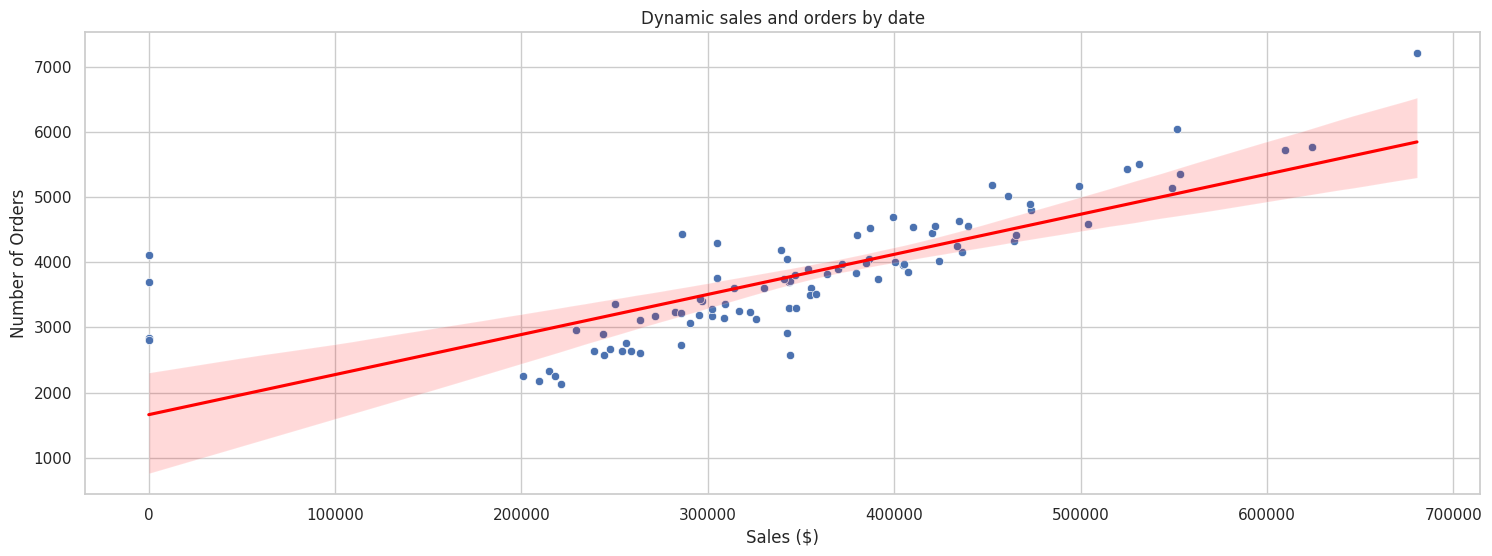

,session_count,total_sales
session_count,1.000000,0.791081
total_sales,0.791081,1.000000


'P-value: 0.0000'

In [ ]:
from scipy.stats import pearsonr
sales_and_orders_by_date = df.groupby(pd.Grouper(key='date', axis=0, freq='D')).agg(session_count=('ga_session_id', 'count'), total_sales=('price', 'sum'))
sns.set_style('whitegrid')
plt.figure(figsize=(18, 6))
sns.scatterplot(data=pd.DataFrame(sales_and_orders_by_date), x='total_sales', y='session_count')
sns.regplot(data=pd.DataFrame(sales_and_orders_by_date), x='total_sales', y='session_count', scatter=False, color='red')
plt.title('Orders vs Sales - Basic Correlation')
plt.xlabel('Sales ($)')
plt.ylabel('Number of Orders')
plt.title('Dynamic sales and orders by date')
plt.show()
display(sales_and_orders_by_date.corr())
_, p_value = pearsonr(sales_and_orders_by_date['session_count'], sales_and_orders_by_date['total_sales'])
display(f'P-value: {p_value:.4f}')

Маємо чітку позитивну кореляцію між кількістю замовлень на день та продажами. Коефіцієнт кореляції дуже високий між замовленнями та продажами. P-value вказуе на статистичну занчущість.

In [ ]:
# Функція для відображення діаграми та показників кореляції даних
from scipy.stats import pearsonr
def corr_matrix_diagram(df):
  correlation_matrix = df.corr()

  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            fmt='.3f')
  plt.title('Кореляція')
  plt.tight_layout()
  plt.show()

  print("кореляцій:")
  corr_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
      entity1 = correlation_matrix.columns[i]
      entity2 = correlation_matrix.columns[j]
      corr_value = correlation_matrix.iloc[i, j]
      corr_pairs.append((f"{entity1} - {entity2}", corr_value))

  corr_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

  for pair, corr in corr_pairs[:10]:
    print(f"{pair}: {corr:.3f}")

  print(f"\nСтатистична значущість (p-values):")
  for pair, corr in corr_pairs[:5]:
    entity = pair.split(' - ')
    _, p_value = pearsonr(df[entity[0]], df[entity[1]])
    significance = "значуща" if p_value < 0.05 else "незначуща"
    print(f"{pair}: p = {p_value:.4f} ({significance})")


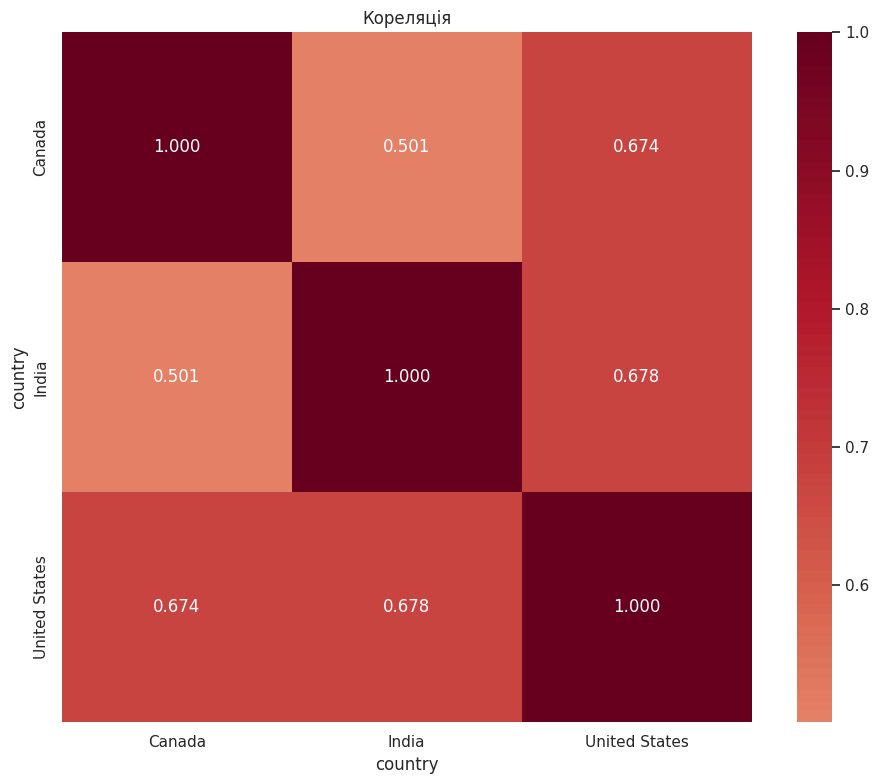

кореляцій:
India - United States: 0.678
Canada - United States: 0.674
Canada - India: 0.501

Статистична значущість (p-values):
India - United States: p = 0.0000 (значуща)
Canada - United States: p = 0.0000 (значуща)
Canada - India: p = 0.0000 (значуща)


In [ ]:
sales_by_country = pd.pivot_table(df, index='date', columns='country', values='price', aggfunc='sum', observed=True, fill_value=0)
top_countries = df.groupby('country', observed=True).agg(total_sum=('price', 'sum')).reset_index().sort_values(by = 'total_sum', ascending=False).nlargest(3, 'total_sum')
top_countries['country'] = top_countries['country'].cat.remove_unused_categories()
top_countries = top_countries['country'].cat.categories.values
sales_by_country = sales_by_country[top_countries]
corr_matrix_diagram(sales_by_country)

Маємо p-value 0, що вказує на статистичну значущість. Позитивна середня кореляція між продажами у парах Канада-Штати та Індія-Штати. Слаба позитивна кореляція між Канадою та Індією.

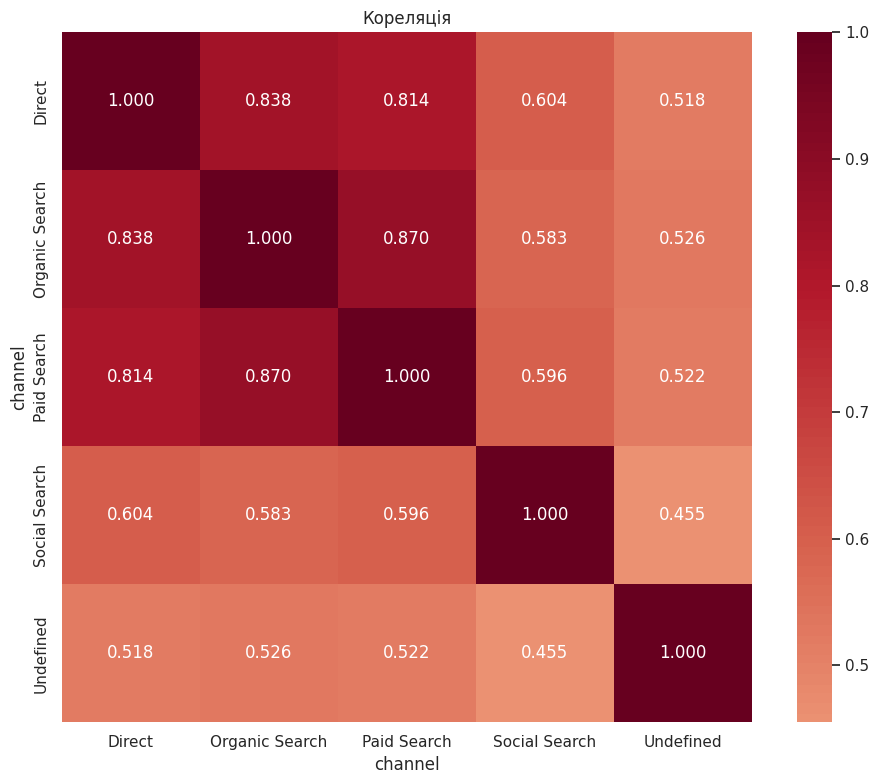

кореляцій:
Organic Search - Paid Search: 0.870
Direct - Organic Search: 0.838
Direct - Paid Search: 0.814
Direct - Social Search: 0.604
Paid Search - Social Search: 0.596
Organic Search - Social Search: 0.583
Organic Search - Undefined: 0.526
Paid Search - Undefined: 0.522
Direct - Undefined: 0.518
Social Search - Undefined: 0.455

Статистична значущість (p-values):
Organic Search - Paid Search: p = 0.0000 (значуща)
Direct - Organic Search: p = 0.0000 (значуща)
Direct - Paid Search: p = 0.0000 (значуща)
Direct - Social Search: p = 0.0000 (значуща)
Paid Search - Social Search: p = 0.0000 (значуща)


In [ ]:
# Чи корелюють між собою продажі за різними каналами трафіку? Проаналізуй статистичну значущість взаємозв’язків.
sales_by_channel = pd.pivot_table(df, index='date', columns='channel', values='price', aggfunc='sum', observed=True, fill_value=0)
corr_matrix_diagram(sales_by_channel)

P-value вказую на статистичну значущість даних. Позитивна сильна кореляція у парах: Organic Search - Paid Search, Direct - Organic Search, Direct - Paid Search. Позитивна слабка кореляція по парах: Direct - Social Search, Paid Search - Social Search, Organic Search - Undefined, Organic Search - Social Search, Paid Search - Undefined, Direct - Undefined, Social Search - Undefined

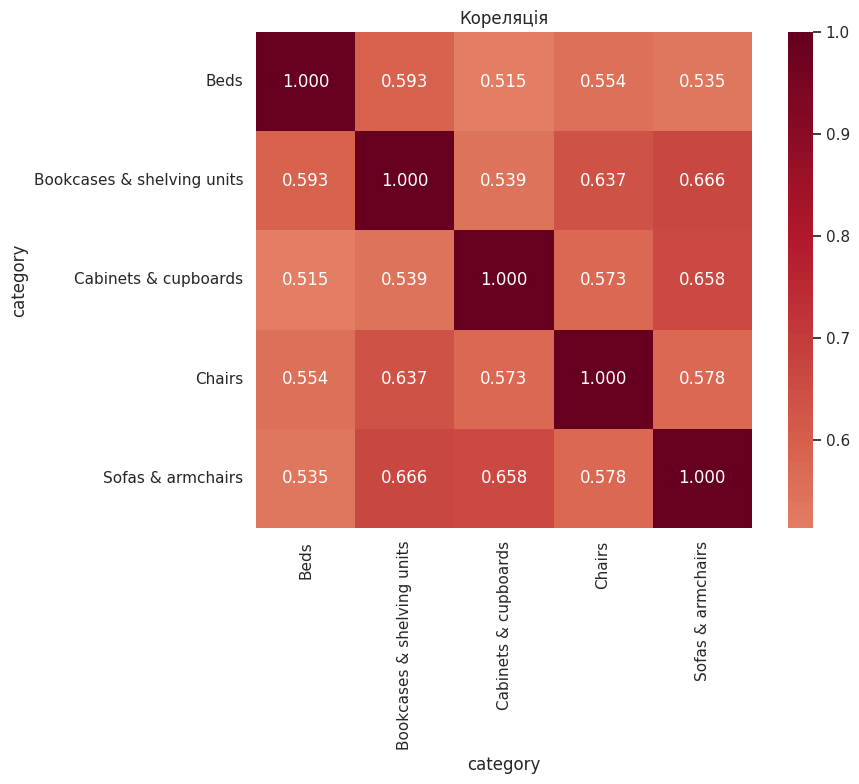

кореляцій:
Bookcases & shelving units - Sofas & armchairs: 0.666
Cabinets & cupboards - Sofas & armchairs: 0.658
Bookcases & shelving units - Chairs: 0.637
Beds - Bookcases & shelving units: 0.593
Chairs - Sofas & armchairs: 0.578
Cabinets & cupboards - Chairs: 0.573
Beds - Chairs: 0.554
Bookcases & shelving units - Cabinets & cupboards: 0.539
Beds - Sofas & armchairs: 0.535
Beds - Cabinets & cupboards: 0.515

Статистична значущість (p-values):
Bookcases & shelving units - Sofas & armchairs: p = 0.0000 (значуща)
Cabinets & cupboards - Sofas & armchairs: p = 0.0000 (значуща)
Bookcases & shelving units - Chairs: p = 0.0000 (значуща)
Beds - Bookcases & shelving units: p = 0.0000 (значуща)
Chairs - Sofas & armchairs: p = 0.0000 (значуща)


In [ ]:
sales_by_category = pd.pivot_table(df, index='date', columns='category', values='price', aggfunc='sum', observed=True, fill_value=0)
top_categories = df.groupby('category', observed=True).agg(total_sum=('price', 'sum')).reset_index().sort_values(by = 'total_sum', ascending=False).nlargest(5, 'total_sum')
top_categories['category'] = top_categories['category'].cat.remove_unused_categories()
top_categories = top_categories['category'].cat.categories.values
sales_by_category = sales_by_category[top_categories]
corr_matrix_diagram(sales_by_category)

P-value вказує на статистично значущі дані. Позитивна середня кореляція між всіма парами категорій товарів з ТОП 10

Статистичний аналіз відмінностей між групами

In [ ]:
df['state'] = df['id'].apply(lambda x: 'unregistered' if pd.isna(x) else 'registered')
sales_by_state = pd.pivot_table(df, index='date', columns='state', values='ga_session_id', aggfunc='count', observed=True, fill_value=0)

from scipy.stats import shapiro, mannwhitneyu, ttest_ind

stat1, p1 = shapiro(sales_by_state['unregistered'])
stat2, p2 = shapiro(sales_by_state['registered'])

print(f"Registered: p = {p1:.4f}")
print(f"Unregistered: p = {p2:.4f}")

stat, p = mannwhitneyu(sales_by_state['unregistered'], sales_by_state['registered'], alternative='two-sided')
print(f"Mann-Whitney U test: p = {p:.4f}")

Registered: p = 0.0382
Unregistered: p = 0.0003
Mann-Whitney U test: p = 0.0000


Обидві виборки зареєстрованих та незареєстрованих користувачів не є нормальними. P-value вказує на те що існує різниця між кількістю сесії зареєстрованих користувачів та незареєстрованих.

Group Direct: p = 0.0343
Group Organic Search: p = 0.0123
Group Paid Search: p = 0.0108
Group Social Search: p = 0.1413
Group Undefined: p = 0.0546
Kruskal-Wallis p = 0.0000


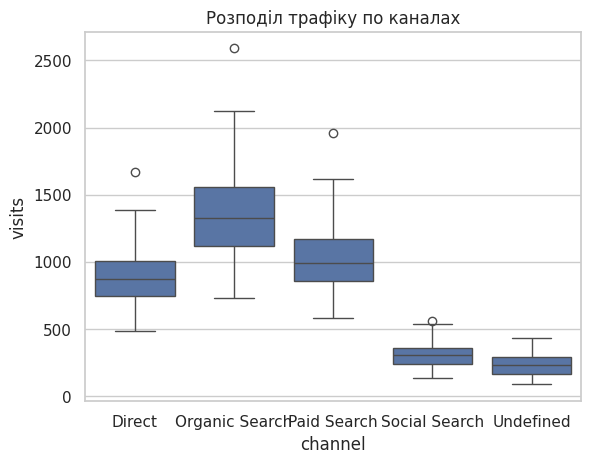

In [ ]:
from scipy.stats import kruskal, f_oneway
sessions_by_channel = pd.pivot_table(df, index='date', columns='channel', values='ga_session_id', aggfunc='count', observed=True, fill_value=0)

groups = [sessions_by_channel[col] for col in sessions_by_channel.columns]

for i, g in enumerate(groups):
    p = shapiro(g).pvalue
    print(f"Group {sessions_by_channel.columns[i]}: p = {p:.4f}")

if all(shapiro(g).pvalue > 0.05 for g in groups):
    stat, p = f_oneway(*groups)
    print(f"ANOVA p = {p:.4f}")
else:
    stat, p = kruskal(*groups)
    print(f"Kruskal-Wallis p = {p:.4f}")

df_melted = sessions_by_channel.melt(var_name='channel', value_name='visits')
sns.boxplot(data=df_melted, x='channel', y='visits')
plt.title("Розподіл трафіку по каналах")
plt.show()

Оскільки нам потрібно порівняти декілька груп, обираємо тести Kruscal, та ANOVA однофакторний. За результатами що група Organic Search та Paid Search не мають нормального розподілу. Тест Kruscal вказує на те що групи суттєво відрізняються. Для зъясування які групи виділяються робимо діаграму boxplot. Візуалізация підтверджує анмальні викиди по групах Organic Search та Paid Search.

In [ ]:
organic_by_continent = pd.pivot_table(df[df['channel'] == 'Organic Search'], index='date', columns='continent', values='ga_session_id', aggfunc='count', observed=True, fill_value=0)
organic_by_continent = organic_by_continent[['Americas','Europe']]
stat1, p1 = shapiro(organic_by_continent['Americas'])
stat2, p2 = shapiro(organic_by_continent['Europe'])
print(f"Americas: p = {p1:.4f}")
print(f"Europe: p = {p2:.4f}")
if p1 > 0.05 and p2 > 0.05:
  stat, p = ttest_ind(organic_by_continent['Americas'], organic_by_continent['Europe'])
  print(f"Used t-test, p-value = {p:.4f}")
else:
  stat, p = mannwhitneyu(organic_by_continent['Americas'], organic_by_continent['Europe'])
  print(f"Used Mann-Whitney U, p-value = {p:.4f}")

Americas: p = 0.0145
Europe: p = 0.0389
Used Mann-Whitney U, p-value = 0.0000


Одна з виборок не є нормальною за розподілом, використовуюємо тест Mann-Whitney. P-value вказує на суттєву різницю між групами.

In [ ]:
# Експортуємо датафрейм у тектовий файл для роботи з Tableu
from google.colab import drive
drive.mount('/content/drive')
df.to_csv('/content/drive/MyDrive/MateAcademy/Projects/portfolio_project.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://public.tableau.com/views/portfolio_project_17544230645860/Sales?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link